<a href="https://colab.research.google.com/github/rrajasek95/nlp-243-notebooks/blob/main/Section_05_Text_Classification_using_MLP_and_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using PyTorch

In [ ]:
import os
import spacy # Text preprocessing

# Pytrch
import torch
import torch.nn as nn # Neural Net Layers module
import torch.optim as optim # Optimizers module
import torch.nn.functional as F # Functions module - activations, utilities like padding
import numpy as np

from tqdm.auto import tqdm # Add progress bar

from torch.utils.data import DataLoader, Dataset # Preparing data in batches for pytorch training

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import math
from itertools import chain

# Gensim word embeddings
import gensim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## BBC News Dataset

The BBC News Dataset is a small collection of news articles from 5 different topics - business, entertainment, politics, tech, sports.

Therfore, this makes for a pretty decent dataset for article classification.

In [ ]:
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!unzip bbc-fulltext.zip


--2020-11-16 22:14:25--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874078 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  2.85MB/s    in 1.0s    

2020-11-16 22:14:27 (2.85 MB/s) - ‘bbc-fulltext.zip’ saved [2874078/2874078]

Archive:  bbc-fulltext.zip
   creating: bbc/
   creating: bbc/business/
  inflating: bbc/business/001.txt    
  inflating: bbc/business/002.txt    
  inflating: bbc/business/003.txt    
  inflating: bbc/business/004.txt    
  inflating: bbc/business/005.txt    
  inflating: bbc/business/006.txt    
  inflating: bbc/business/007.txt    
  inflating: bbc/business/008.txt    
  inflating: bbc/business/009.txt    
  inflating: bbc/business/010.txt    
  inflating: bbc/business/011.txt    
  inflating: bbc/business/012.txt   

In [ ]:
!cat bbc/business/001.txt

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

### Download Word2Vec Wikipedia embeddings

In [ ]:
# !wget http://vectors.nlpl.eu/repository/20/4.zip
# The above Gigaword vectors require part-of-speech information. Think about how you'll use these
# in your model - this would work better than context-free word embeddings

!wget http://vectors.nlpl.eu/repository/20/6.zip

--2020-11-16 22:15:12--  http://vectors.nlpl.eu/repository/20/6.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 635351287 (606M) [application/zip]
Saving to: ‘6.zip’

6.zip               100%[===================>] 605.92M  5.72MB/s    in 1m 45s  

2020-11-16 22:16:58 (5.75 MB/s) - ‘6.zip’ saved [635351287/635351287]



In [ ]:
# !unzip 4.zip gigaword
!unzip 6.zip -d wikipedia

Archive:  6.zip
  inflating: wikipedia/meta.json     
  inflating: wikipedia/model.bin     
  inflating: wikipedia/model.txt     
  inflating: wikipedia/README        


In [ ]:
word2vec_weights = gensim.models.KeyedVectors.load_word2vec_format("wikipedia/model.txt") # Load embeddings into Gensim class containing matrix

## Prepare dataset

In [ ]:
def load_bbc_dataset(dataset_path):

    data = []

    for topic in ['business', 'entertainment', 'politics', 'sport', 'tech']:

        topic_path = os.path.join(dataset_path, topic)
        for filename in os.listdir(topic_path):
            file_path = os.path.join(topic_path, filename)

            try:
                with open(file_path, 'r') as text_file:
                    text = text_file.read()

                data.append((text, topic)) # (X = article text, y = article topic)
            except UnicodeDecodeError:
                print("Failed to read:", file_path,"! Skipping")
    
    return data

In [ ]:
data = load_bbc_dataset('bbc')

Failed to read: bbc/sport/199.txt ! Skipping


In [ ]:
texts, labels = zip(*data)

In [ ]:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(texts, labels, stratify=labels)

## Feature Builder Classes

In [ ]:
# We'll be using SkLearn's TfIdfVectorizer to construct our n-gram feature vectors

# We'll create our custom sequencer class for converting a text into a sequence of integers corresponding to our tokens
# Input : "Hello, my name is Rishi"
# Output: [4, 3, 2 5, 6 , 7 ] # 4: Hello, 3: ',', 2: 'my', ... , 7: 'Rishi'
# We want the indices to access the vectors for the given word
# 4 - Index of vector corresponding to the word 'Hello'

# Our word vectors:
# 0 (say) [-0.016457 0.005666 0.021893 0.036763 -0.099810 0.020892 -0.023565 0.061527 -0.064225 -0.127303 -0.029338 0.054085 -0.028404 -0.021510 -0.099026 -0.030219 -0.113324 0.159025 -0.006395 -0.012752 -0.043114 0.055606 0.008410 -0.057141 0.150728 0.022703 0.059621 0.036312 0.081985 -0.036570 -0.057276 -0.105478 -0.004486 -0.064055 -0.125824 -0.076262 0.066562 -0.185299 -0.004718 -0.106012 0.078044 -0.049623 -0.019707 0.024215 0.070698 0.128529 -0.036913 -0.000408 -0.053999 -0.000760 0.011069 -0.037236 0.038052 0.047209 -0.000934 0.014226 -0.101589 -0.021408 0.037043 0.028972 -0.048394 -0.048568 0.023561 0.050198 0.002572 0.029351 -0.097906 0.068975 0.066806 -0.002132 0.041009 -0.013165 -0.001345 0.027810 -0.056385 -0.024247 -0.029757 0.031317 -0.020337 0.054462 0.089233 -0.126477 0.026837 -0.037890 0.143336 0.012796 -0.030611 0.113524 0.080372 -0.006593 -0.039996 -0.002388 0.020406 -0.005260 0.013018 -0.004855 0.000909 0.024569 0.032159 0.085467 0.002894 -0.002156 0.075847 -0.027901 0.162719 -0.017862 -0.020725 -0.013756 0.032742 -0.107903 -0.020145 0.104665 -0.048859 0.127686 0.065073 0.025002 0.036685 -0.015755 0.096920 0.061627 -0.018842 -0.055340 0.040091 0.063783 0.040945 0.132622 0.036789 -0.045669 0.042439 0.057564 0.002319 0.078522 -0.043101 0.024797 0.029955 -0.063213 -0.066685 -0.057995 0.044187 0.013773 0.049962 0.011659 -0.073489 0.085285 -0.002402 0.082264 0.110752 -0.091364 -0.082374 0.020575 -0.089784 -0.034675 -0.023478 -0.012981 -0.075382 -0.087736 0.101732 -0.049771 0.073409 0.105999 -0.008192 0.051214 0.005423 0.003315 0.051006 -0.072713 0.098589 -0.044787 0.030751 0.029813 -0.005148 0.005983 -0.043757 -0.030320 0.013599 0.009227 -0.028190 0.031872 -0.056918 0.047188 0.086135 0.053166 -0.081615 0.071527 0.085285 -0.034258 -0.095423 0.090446 0.049369 0.025583 0.022480 0.019886 0.095464 -0.025733 -0.054728 -0.028570 0.022430 -0.012296 0.039433 0.041846 -0.052139 -0.056371 0.079290 0.080066 0.027186 0.012930 -0.018256 -0.016459 0.060026 -0.042765 -0.020518 0.006542 -0.100084 -0.047055 0.098878 0.008997 0.043938 0.044421 0.013212 0.014310 0.008998 0.045343 -0.001792 0.043302 -0.082872 -0.063939 0.019913 0.047750 -0.058111 0.019319 -0.109353 -0.050987 -0.003592 -0.028676 -0.043118 0.039557 0.036327 -0.032287 0.021005 0.018498 -0.017329 0.009347 -0.004317 0.013634 -0.087900 -0.049935 0.007746 -0.038557 0.016165 -0.001408 -0.021590 -0.021483 0.041102 0.034813 0.024639 -0.014953 0.034395 0.042431 -0.034290 0.113096 0.028386 0.012610 0.113622 0.099868 -0.047553 -0.055141 0.081419 0.060897 0.033517 0.070338 0.040594 0.008233 0.002827 -0.048878 -0.006415 0.004285 -0.038513 0.050271 -0.026621 -0.035559 0.085345 -0.006597 0.023721 -0.046521 -0.052554 -0.081140 -0.101331 -0.006354 0.060702 0.041869 0.001872 -0.029082 -0.040995 -0.042205 -0.024152 -0.061239 0.037529 -0.052604 0.073380 0.021318]
# 1 (year) [-0.020862 0.091081 0.030143 0.044928 -0.039632 -0.052762 0.086554 -0.033820 -0.039126 -0.049076 0.019706 -0.016391 0.039894 0.070685 -0.009264 0.013761 -0.014918 -0.005033 -0.026868 0.139029 -0.092375 0.072021 0.086156 0.060858 0.022265 0.070539 -0.000366 -0.077498 0.074328 0.018448 -0.133731 -0.070511 -0.007111 -0.090394 -0.002611 -0.077230 0.020074 0.065541 0.003582 -0.071871 0.076368 -0.007130 0.053619 0.000117 -0.002221 0.011619 -0.099297 -0.032122 -0.021738 -0.005857 0.035957 -0.015488 -0.054147 0.045498 -0.023322 -0.028272 -0.012185 -0.088205 0.069354 0.032746 0.047092 -0.083746 -0.030912 0.061607 0.102859 -0.011405 -0.007592 -0.013440 0.083539 0.028081 -0.004936 0.017838 0.070643 -0.039028 -0.017780 -0.090181 -0.076588 -0.001165 0.036132 -0.102343 0.106976 0.015121 0.054096 -0.043179 -0.042845 -0.013959 -0.044288 0.061936 -0.042800 0.049818 -0.005679 -0.040999 0.007476 0.041139 -0.020163 -0.072105 0.067300 -0.024149 0.047047 -0.012251 0.021856 -0.230840 -0.069708 -0.128597 0.046794 0.003120 -0.098918 0.038630 0.015836 0.041364 0.004654 0.030140 -0.026638 -0.040064 -0.004387 0.033325 -0.028964 0.063713 0.082938 0.047717 -0.028720 -0.000124 -0.058471 0.054698 -0.077716 0.014115 0.045998 -0.039880 0.037951 -0.022623 -0.073551 -0.029734 -0.006686 -0.046788 -0.047048 0.048809 0.065685 -0.094081 0.009960 0.040303 0.109173 -0.079072 -0.038558 0.043107 -0.046333 -0.051847 -0.055877 0.035927 -0.000557 -0.028910 -0.001796 0.009779 0.070724 -0.076734 -0.049698 -0.051177 -0.010030 -0.032417 0.112298 -0.048902 -0.110678 0.024402 -0.093728 0.013824 0.027871 -0.020682 -0.000717 0.087400 0.072489 -0.054522 -0.016094 -0.073715 -0.037509 0.001349 -0.107182 0.002886 -0.007559 -0.038211 0.006419 -0.116266 0.035283 -0.045140 0.036843 0.087636 -0.004077 0.071094 0.029225 0.058551 0.066372 0.092901 0.043376 -0.007894 0.005130 -0.070292 -0.052419 -0.028484 0.089438 -0.008769 -0.055218 0.019262 0.033993 0.008990 0.143733 -0.010378 0.078207 -0.031403 0.004595 -0.095942 -0.056159 0.050025 -0.027929 -0.024954 -0.114869 -0.073308 0.035274 -0.097693 -0.029095 -0.020764 -0.005055 0.009123 0.021029 -0.123420 0.029189 -0.003864 0.081216 0.044239 -0.149860 -0.049339 0.064162 0.108673 0.028682 -0.057684 0.019785 -0.004504 -0.115881 0.052063 0.119204 0.009445 -0.049341 -0.054128 0.065719 -0.006246 0.065020 0.005824 -0.094724 -0.091890 0.064122 -0.080926 0.031800 -0.029981 0.018315 -0.034446 0.021722 0.071480 -0.060150 -0.064157 0.015135 -0.054347 -0.010469 0.031822 0.011353 -0.066325 -0.103637 -0.053428 0.021063 -0.063239 -0.027001 0.004307 -0.055074 -0.036124 -0.058356 -0.004795 0.007763 -0.019251 0.068137 -0.048656 -0.087174 -0.046017 -0.067088 -0.023913 0.057596 0.070647 0.042291 0.029272 -0.065840 -0.045579 -0.084960 -0.014945 0.117556 -0.029472 0.023953 0.036586 0.027706 -0.081025 -0.004470 -0.034535 0.033065 -0.054836 -0.043534 -0.055042]
# 314814 (wn) [-0.020862 0.091081 0.030143 0.044928 -0.039632 -0.052762 0.086554 -0.033820 -0.039126 -0.049076 0.019706 -0.016391 0.039894 0.070685 -0.009264 0.013761 -0.014918 -0.005033 -0.026868 0.139029 -0.092375 0.072021 0.086156 0.060858 0.022265 0.070539 -0.000366 -0.077498 0.074328 0.018448 -0.133731 -0.070511 -0.007111 -0.090394 -0.002611 -0.077230 0.020074 0.065541 0.003582 -0.071871 0.076368 -0.007130 0.053619 0.000117 -0.002221 0.011619 -0.099297 -0.032122 -0.021738 -0.005857 0.035957 -0.015488 -0.054147 0.045498 -0.023322 -0.028272 -0.012185 -0.088205 0.069354 0.032746 0.047092 -0.083746 -0.030912 0.061607 0.102859 -0.011405 -0.007592 -0.013440 0.083539 0.028081 -0.004936 0.017838 0.070643 -0.039028 -0.017780 -0.090181 -0.076588 -0.001165 0.036132 -0.102343 0.106976 0.015121 0.054096 -0.043179 -0.042845 -0.013959 -0.044288 0.061936 -0.042800 0.049818 -0.005679 -0.040999 0.007476 0.041139 -0.020163 -0.072105 0.067300 -0.024149 0.047047 -0.012251 0.021856 -0.230840 -0.069708 -0.128597 0.046794 0.003120 -0.098918 0.038630 0.015836 0.041364 0.004654 0.030140 -0.026638 -0.040064 -0.004387 0.033325 -0.028964 0.063713 0.082938 0.047717 -0.028720 -0.000124 -0.058471 0.054698 -0.077716 0.014115 0.045998 -0.039880 0.037951 -0.022623 -0.073551 -0.029734 -0.006686 -0.046788 -0.047048 0.048809 0.065685 -0.094081 0.009960 0.040303 0.109173 -0.079072 -0.038558 0.043107 -0.046333 -0.051847 -0.055877 0.035927 -0.000557 -0.028910 -0.001796 0.009779 0.070724 -0.076734 -0.049698 -0.051177 -0.010030 -0.032417 0.112298 -0.048902 -0.110678 0.024402 -0.093728 0.013824 0.027871 -0.020682 -0.000717 0.087400 0.072489 -0.054522 -0.016094 -0.073715 -0.037509 0.001349 -0.107182 0.002886 -0.007559 -0.038211 0.006419 -0.116266 0.035283 -0.045140 0.036843 0.087636 -0.004077 0.071094 0.029225 0.058551 0.066372 0.092901 0.043376 -0.007894 0.005130 -0.070292 -0.052419 -0.028484 0.089438 -0.008769 -0.055218 0.019262 0.033993 0.008990 0.143733 -0.010378 0.078207 -0.031403 0.004595 -0.095942 -0.056159 0.050025 -0.027929 -0.024954 -0.114869 -0.073308 0.035274 -0.097693 -0.029095 -0.020764 -0.005055 0.009123 0.021029 -0.123420 0.029189 -0.003864 0.081216 0.044239 -0.149860 -0.049339 0.064162 0.108673 0.028682 -0.057684 0.019785 -0.004504 -0.115881 0.052063 0.119204 0.009445 -0.049341 -0.054128 0.065719 -0.006246 0.065020 0.005824 -0.094724 -0.091890 0.064122 -0.080926 0.031800 -0.029981 0.018315 -0.034446 0.021722 0.071480 -0.060150 -0.064157 0.015135 -0.054347 -0.010469 0.031822 0.011353 -0.066325 -0.103637 -0.053428 0.021063 -0.063239 -0.027001 0.004307 -0.055074 -0.036124 -0.058356 -0.004795 0.007763 -0.019251 0.068137 -0.048656 -0.087174 -0.046017 -0.067088 -0.023913 0.057596 0.070647 0.042291 0.029272 -0.065840 -0.045579 -0.084960 -0.014945 0.117556 -0.029472 0.023953 0.036586 0.027706 -0.081025 -0.004470 -0.034535 0.033065 -0.054836 -0.043534 -0.055042]
# VOCAB_SIZE x 300 Matrix

class Sequencer(object):
    def __init__(self, corpus, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}

        self.unk_index = self.add_token(unk_token) 
        self.pad_index = self.add_token(pad_token)
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)
        self.nlp = spacy.load('en')
        self.tokenizer = lambda text: [t.text for t in self.nlp(text)]

    def add_token(self, token):

        self.word2idx[token] = new_index = len(self.word2idx)
        self.idx2word[new_index] = token

        return new_index

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        tokens = self.tokenizer(text)

        sequence = [self.bos_index]
        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length

        max_seq_len = max(len(sequence) for sequence in sequences)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor

class W2VSequencer(object):
    def __init__(self, gensim_w2v):
        # Performs the same thing as the previous class
        # Except it uses the vocabulary of words from the word embeddings we use

        self.nlp = spacy.load('en')
        self.w2v = gensim_w2v
        self.w2v.add(['<unk>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])

        self.unk_index = self.w2v.vocab.get('<unk>')
        self.tokenizer = lambda text: [t.text for t in self.nlp(text)]

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        sequence = []
        tokens = self.tokenizer(text)
        for token in tokens:

            index = self.w2v.vocab.get(token, self.unk_index).index
            sequence.append(index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Given a list of sequences, pad all to the same length

        max_seq_len = max(len(sequence) for sequence in sequences)
        tensor = torch.full((len(sequences), max_seq_len), 0, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor

# For converting labels into indices 0 - L1, 1 - L2
class LabelIndexer(object):
    def __init__(self, labels):
        self.label2idx = {label: i for i, label in enumerate(labels)}
        self.idx2label = {i:label for label, i in self.label2idx.items()}
        self.labels = labels

    def encode(self, y):
        return self.label2idx[y]

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])


## Dataset class

In [ ]:
class BBCNewsDataset(Dataset):
    # This class is an interface for our training/test dataset
    # with pytorch

    # It prepares our training/test examples into a form that pytorch expects
    # Input: ["Warner Bros gets $1m profit ", "business"]
    # Output: [[TFIDF/Word Vector for text, 0]]
    def __init__(self, texts, labels, input_transformer, output_transformer):
        self.texts = texts
        self.labels = labels
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def __getitem__(self, index): # Return a single example
    
        text = self.texts[index]
        label = self.labels[index]
        x = self.input_transformer(text) # Produces TF-IDF/List of indices from text
        y = self.output_transformer(label) # Produces index from the label text i.e. "business" to 0
        
        return x, y

    def __len__(self):
        return len(self.texts)

## Model classes

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_size, output_size, bias=True) # y = Wx + b

    def forward(self, x):
        return self.fc(x) # Compute y = Wx + b

class MultiLayerPerceptron(nn.Module):
    """
    At its simplest, a multilayer perceptron is a 2 layer network
    """

    def __init__(self, input_size, hidden_size, output_size, dropout=False, dropout_p=0.1):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=True)

        self.add_dropout = dropout
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        if self.add_dropout:
            logits = self.fc2(self.dropout(h))
        else:
            logits = self.fc2(h)

        return logits
    

class TextConvolver(nn.Module):
    """
    This model is based on "Convolutional Neural Networks for Sentence Classification" 
    described here (Kim 2014):
    https://arxiv.org/pdf/1408.5882.pdf

    I modified the implemenation defined here:
    https://github.com/Shawn1993/cnn-text-classification-pytorch/blob/master/model.py

    The contributors use 2D Cnns with kernel size (1 x K), but we can replace
    those with 1D convolutions with kernel size K.

    Additionally, we use pretrained word embeddings (English Wikipedia skip-gram)
    for our prediction, unlike the original paper which uses Word2Vec 
    100 billion words.
    """
    def __init__(self, input_size, output_size, kernel_sizes, channel_size=32, dropout=False, dropout_p=0.1, w2v_weights=None):
        super(TextConvolver, self).__init__()

        # Embedding: takes an integer index representing the word, and returns the corresponding vector for that word
        self.embedding = nn.Embedding.from_pretrained(w2v_weights)
        # self.embedding = nn.Embedding(vocab_size, embedding_dim) - nn.Embedding(314815, 300)
        embed_dim = 300

        self.frozen_embedding = nn.Embedding.from_pretrained(w2v_weights)
        self.frozen_embedding.requires_grad = False # Disable gradient updates, freezes the parameters from updates during training

        # Input
        # Perform convolution over it
        # Pass it through an activation
        # 

        self.add_dropout = dropout
        self.dropout = nn.Dropout(dropout_p)

        # Define an iterable set of parallel layers which are given the same input
        self.convs = nn.ModuleList([nn.Conv1d(2 * embed_dim, channel_size, kernel_size) for kernel_size in kernel_sizes])

        self.fc = nn.Linear(len(kernel_sizes) * channel_size, output_size)



    def forward(self, x):
        # x size: [batch_size, seq_len]
        # After embedding: [batch_size, seq_len, emb_dim = 300] # 16 * 100 * 300 
        # After transposing it: [batch_size, emb_dim, seq_len]

        embed = self.embedding(x).transpose(1, 2) # Trainable embedding
        embed_frozen = self.frozen_embedding(x).transpose(1, 2) # Frozen embedding

        # embed/embed_frozen shape: [batch_size, embed_dim, seq_len]

        combined_embedding = torch.cat((embed, embed_frozen), dim=1)
        # combined_embedding shape: [batch_size, 2*embed_dim, seq_len]

        convs = [F.relu(conv(combined_embedding)) for conv in self.convs]
        # [num_filters, (batch_size, out_dim_i, seq_len_i)] # output dimensions and seq_lens for each convoluational filter may be different

        maxs = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in convs] # Max pool across time
        # After max pooling: [num_filters, (batch_size, channel_size, 1)]
        # After squeezing: [num_filters, (batch_size, channel_size)]

        flattened_maxs = torch.cat(maxs, dim=1)
        # [batch_size, num_filters * channel_size]


        # logits shape: [batch_size, output_size] ; batch size * num classes
        logits = self.fc(self.dropout(flattened_maxs))

        return logits

## Trainer Class

In [ ]:
class MultiClassTrainer(object):
    """
    Trainer for training a multi-class classification model
    """

    def __init__(self, model, optimizer, loss_fn, device="cpu", log_every_n=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn
        
        self.log_every_n = log_every_n if log_every_n else 0


    def _print_summary(self):
        print(self.model)
        print(self.optimizer)
        print(self.loss_fn)

    def train(self, loader):
        """
        Run a single epoch of training
        """

        self.model.train() # Run model in training mode

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        for i, batch in tqdm(enumerate(loader)):
            batch_size = batch[0].shape[0]
            self.optimizer.zero_grad() # Always set gradient to 0 before computing it

            logits = self.model(batch[0].to(self.device)) # __call__ model() in this case: __call__ internally calls forward()
            # [batch_size, num_classes]

            loss = self.loss_fn(logits, batch[1].view(-1).to(self.device)) # Compute loss: Cross entropy loss

            loss_history.append(loss.item())

            

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            if self.log_every_n and i % self.log_every_n == 0:
                print("Running loss: ", running_loss)

            running_loss_history.append(running_loss)

            loss.backward() # Perform backprop, which will compute dL/dw

            nn.utils.clip_grad_norm_(self.model.parameters(), 3.0) # We clip gradient's norm to 3

            self.optimizer.step() # Update step: w = w - eta * dL / dW : eta = 1e-2 (0.01), gradient = 5e30; update value of 5e28

        print("Epoch completed!")
        print("Epoch Loss: ", running_loss)
        print("Epoch Perplexity: ", math.exp(running_loss))

        # The history information can allow us to draw a loss plot
        return loss_history, running_loss_history

    def evaluate(self, loader, labels):
        """
        Evaluate the model on a validation set
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)

        batch_wise_true_labels = []
        batch_wise_predictions = []

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch in tqdm(enumerate(loader)):
                # batch[0] shape: (batch_size, input_size)

                logits = self.model(batch[0].to(self.device)) # Run forward pass (except we don't store gradients)
                # logits shape: (batch_size, num_classes)
                
                loss = self.loss_fn(logits, batch[1].view(-1).to(self.device)) # Compute loss
                # No backprop is done during validation
                
                # Instead of using CrossEntropyLoss, you use BCEWithLogitsLoss
                # BCEWithLogitsLoss - independently calculates loss for each class
                

                loss_history.append(loss.item())

                running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
                
                running_loss_history.append(running_loss)

                # logits : [batch_size, num_classes] and each of the values in logits can be anything (-infinity, +infity)
                # Converts the raw outputs into probabilities for each class using softmax
                probs = F.softmax(logits, dim=-1) 
                # probs shape: (batch_size, num_classes)
                # -1 dimension picks the last dimension in the shape of the tensor, in this case 'num_classes'
                

                # softmax vector: [[0.1, 0.2, 0.6, 0.1, 0.0], [0.9, 0.01, 0.01, 0.01, 0.07]]
                # output tensor: [2, 0]
                predictions = torch.argmax(probs, dim=-1) # Output predictions; Argmax picks the index with the highest probability among all the classes (choosing our most probable class)
                # predictions shape: (batch_size)

                batch_wise_true_labels.append(batch[1].tolist())
                batch_wise_predictions.append(predictions.tolist())
        
        # flatten the list of predictions using itertools
        all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
        all_predictions = list(chain.from_iterable(batch_wise_predictions))

        # Now we can generate a classification report
        print("Classification report after epoch:")
        print(classification_report(all_true_labels, all_predictions, target_names=labels))

        return loss_history, running_loss_history

    def get_model_dict(self):
        return self.model.state_dict()

    def run_training(self, train_loader, valid_loader, labels, n_epochs=10):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        self._print_summary()

        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            loss_history, running_loss_history = self.train(train_loader)
            valid_loss_history, valid_running_loss_history = self.evaluate(valid_loader, labels)

            train_losses.append(loss_history)
            train_running_losses.append(running_loss_history)

            valid_losses.append(valid_loss_history)
            valid_running_losses.append(valid_running_loss_history)

        # Training done, let's look at the loss curves
        all_train_losses = list(chain.from_iterable(train_losses))
        all_train_running_losses = list(chain.from_iterable(train_running_losses))

        all_valid_losses = list(chain.from_iterable(valid_losses))
        all_valid_running_losses = list(chain.from_iterable(valid_running_losses))

        train_epoch_idx = range(len(all_train_losses))
        valid_epoch_idx = range(len(all_valid_losses))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(train_epoch_idx, all_train_running_losses)
        sns.lineplot(valid_epoch_idx, all_valid_running_losses)
        plt.show()

## Data Preparation

In [ ]:
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(train_texts)
input_transformer = lambda text: torch.FloatTensor(tfidf_vec.transform([text]).todense()).squeeze(0) # It takes a sentence and produces a single vector of size VOCAB_SIZE
# Suitable for Models with fixed input size (like MLP)

label_indexer = LabelIndexer(list(set(labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])
# Label "business" to 0, "sports" to 1

# vector: [batch_size, num_classes]
train_tfidf_dataset = BBCNewsDataset(train_texts, train_labels, input_transformer, output_transformer)
valid_tfidf_dataset = BBCNewsDataset(valid_texts, valid_labels, input_transformer, output_transformer)

train_tfidf_loader = torch.utils.data.DataLoader(train_tfidf_dataset, batch_size=16) # Input [16, VOCAB_SIZE] TF-IDF vector, output [Batch_size, num_classes = 5]
valid_tfidf_loader = torch.utils.data.DataLoader(valid_tfidf_dataset, batch_size=16) # Input [16, VOCAB_SIZE] TF-IDF vector, output [Batch_size, num_classes = 5]

# train_sequence_loader = torch.utils.data.DataLoader(train_seq_dataset, batch_size=16)
# valid_sequence_loader = torch.utils.data.DataLoader(valid_seq_dataset, batch_size=16)


## Running Training

In [ ]:
# Define our experimental setup; we use the same parameters for both MLP models
input_size = len(tfidf_vec.vocabulary_)
hidden_size = 100 # An arbitrary hyperparameter we define
output_size = len(label_indexer.label2idx) #
print(input_size)
print(output_size)

# Our experimental hyperparameters
LEARNING_RATE = 1e-2

loss_fn = nn.CrossEntropyLoss() # L = - sum (y_i log (y^i_hat))

26268
5


### Logistic Regression

LogisticRegression(
  (fc): Linear(in_features=26268, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
CrossEntropyLoss()



Epoch completed!
Epoch Loss:  1.5861856880642118
Epoch Perplexity:  4.885080127208984



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.00      0.00      0.00       128
entertainment       0.00      0.00      0.00        96
        sport       0.23      1.00      0.37       128
         tech       0.00      0.00      0.00       100
     politics       0.00      0.00      0.00       104

     accuracy                           0.23       556
    macro avg       0.05      0.20      0.07       556
 weighted avg       0.05      0.23      0.09       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.535293719882057
Epoch Perplexity:  4.642688979767565



Classification report after epoch:
               precision    recall  f1-score   support

     business       1.00      0.30      0.47       128
entertainment       0.00      0.00      0.00        96
        sport       0.25      1.00      0.41       128
         tech       0.00      0.00      0.00       100
     politics       1.00      0.14      0.25       104

     accuracy                           0.33       556
    macro avg       0.45      0.29      0.23       556
 weighted avg       0.48      0.33      0.25       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.4865616741634542
Epoch Perplexity:  4.421865536666508



Classification report after epoch:
               precision    recall  f1-score   support

     business       1.00      0.72      0.84       128
entertainment       1.00      0.01      0.02        96
        sport       0.31      1.00      0.48       128
         tech       1.00      0.14      0.25       100
     politics       1.00      0.40      0.58       104

     accuracy                           0.50       556
    macro avg       0.86      0.45      0.43       556
 weighted avg       0.84      0.50      0.46       556




Epoch completed!
Epoch Loss:  1.4395959956305369
Epoch Perplexity:  4.2189909818479245



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.97      0.84      0.90       128
entertainment       1.00      0.04      0.08        96
        sport       0.37      1.00      0.54       128
         tech       1.00      0.42      0.59       100
     politics       1.00      0.53      0.69       104

     accuracy                           0.60       556
    macro avg       0.87      0.57      0.56       556
 weighted avg       0.85      0.60      0.58       556




Epoch completed!
Epoch Loss:  1.3944653249922254
Epoch Perplexity:  4.03281774922238



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.91      0.90      0.90       128
entertainment       1.00      0.15      0.25        96
        sport       0.45      1.00      0.62       128
         tech       0.96      0.64      0.77       100
     politics       0.98      0.62      0.76       104

     accuracy                           0.69       556
    macro avg       0.86      0.66      0.66       556
 weighted avg       0.84      0.69      0.67       556




Epoch completed!
Epoch Loss:  1.3511476085299536
Epoch Perplexity:  3.8618548862366393



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.92      0.93      0.93       128
entertainment       1.00      0.24      0.39        96
        sport       0.51      1.00      0.68       128
         tech       0.95      0.78      0.86       100
     politics       0.99      0.68      0.81       104

     accuracy                           0.75       556
    macro avg       0.87      0.73      0.73       556
 weighted avg       0.86      0.75      0.74       556




Epoch completed!
Epoch Loss:  1.3096116031919218
Epoch Perplexity:  3.704734525676013



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.89      0.93      0.91       128
entertainment       1.00      0.30      0.46        96
        sport       0.56      1.00      0.72       128
         tech       0.94      0.84      0.89       100
     politics       0.99      0.71      0.83       104

     accuracy                           0.78       556
    macro avg       0.88      0.76      0.76       556
 weighted avg       0.86      0.78      0.77       556




Epoch completed!
Epoch Loss:  1.2698189644586468
Epoch Perplexity:  3.5602079798321493



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.91      0.93      0.92       128
entertainment       1.00      0.40      0.57        96
        sport       0.60      1.00      0.75       128
         tech       0.95      0.88      0.91       100
     politics       0.97      0.75      0.85       104

     accuracy                           0.81       556
    macro avg       0.89      0.79      0.80       556
 weighted avg       0.87      0.81      0.80       556




Epoch completed!
Epoch Loss:  1.2317251557395568
Epoch Perplexity:  3.4271367840566627



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.89      0.95      0.92       128
entertainment       1.00      0.46      0.63        96
        sport       0.65      1.00      0.79       128
         tech       0.94      0.90      0.92       100
     politics       0.98      0.78      0.87       104

     accuracy                           0.83       556
    macro avg       0.89      0.82      0.82       556
 weighted avg       0.88      0.83      0.83       556




Epoch completed!
Epoch Loss:  1.195280514444624
Epoch Perplexity:  3.3044845961628617



Classification report after epoch:
               precision    recall  f1-score   support

     business       0.90      0.95      0.92       128
entertainment       1.00      0.52      0.68        96
        sport       0.68      1.00      0.81       128
         tech       0.94      0.92      0.93       100
     politics       0.98      0.80      0.88       104

     accuracy                           0.85       556
    macro avg       0.90      0.84      0.85       556
 weighted avg       0.89      0.85      0.85       556



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


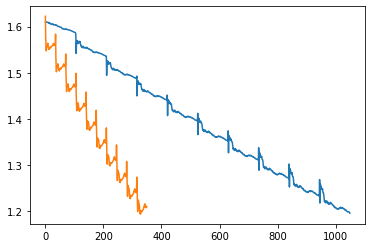

In [ ]:
logistic = LogisticRegression(input_size, output_size)
logistic_optimizer = optim.SGD(logistic.parameters(), lr=LEARNING_RATE, momentum=0.9)

logistic_trainer = MultiClassTrainer(logistic, logistic_optimizer, loss_fn)
logistic_trainer.run_training(train_tfidf_loader, valid_tfidf_loader, label_indexer.labels, n_epochs=10)

### Plain old MLP

MultiLayerPerceptron(
  (fc1): Linear(in_features=26064, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
CrossEntropyLoss()



Epoch completed!
Epoch Loss:  1.603466011229015
Epoch Perplexity:  4.970229475766311



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.23      1.00      0.37       128
entertainment       0.00      0.00      0.00        97
     business       0.00      0.00      0.00       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.23       556
    macro avg       0.05      0.20      0.07       556
 weighted avg       0.05      0.23      0.09       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5897334314527962
Epoch Perplexity:  4.9024419173107



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.23      1.00      0.38       128
entertainment       0.00      0.00      0.00        97
     business       1.00      0.06      0.12       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.24       556
    macro avg       0.25      0.21      0.10       556
 weighted avg       0.28      0.24      0.11       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5692521072569348
Epoch Perplexity:  4.803054680421367



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.26      1.00      0.41       128
entertainment       0.00      0.00      0.00        97
     business       1.00      0.50      0.66       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.34       556
    macro avg       0.25      0.30      0.22       556
 weighted avg       0.29      0.34      0.25       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5308794736862181
Epoch Perplexity:  4.622240173836765



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.32      1.00      0.49       128
entertainment       0.00      0.00      0.00        97
     business       0.77      0.90      0.83       127
     politics       1.00      0.10      0.18       104

     accuracy                           0.45       556
    macro avg       0.42      0.40      0.30       556
 weighted avg       0.44      0.45      0.33       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.4581000838960916
Epoch Perplexity:  4.297786333145668



Classification report after epoch:
               precision    recall  f1-score   support

         tech       1.00      0.51      0.68       100
        sport       0.52      1.00      0.69       128
entertainment       1.00      0.01      0.02        97
     business       0.63      0.96      0.76       127
     politics       0.98      0.62      0.76       104

     accuracy                           0.66       556
    macro avg       0.83      0.62      0.58       556
 weighted avg       0.80      0.66      0.60       556




Epoch completed!
Epoch Loss:  1.3291045268376662
Epoch Perplexity:  3.7776590801939554



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.97      0.91      0.94       100
        sport       0.79      1.00      0.88       128
entertainment       1.00      0.32      0.48        97
     business       0.71      0.99      0.83       127
     politics       0.98      0.86      0.91       104

     accuracy                           0.84       556
    macro avg       0.89      0.82      0.81       556
 weighted avg       0.87      0.84      0.82       556




Epoch completed!
Epoch Loss:  1.133189225764502
Epoch Perplexity:  3.105545007552823



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.93      0.99      0.96       100
        sport       0.96      1.00      0.98       128
entertainment       1.00      0.71      0.83        97
     business       0.85      0.98      0.91       127
     politics       0.94      0.91      0.93       104

     accuracy                           0.93       556
    macro avg       0.94      0.92      0.92       556
 weighted avg       0.93      0.93      0.92       556




Epoch completed!
Epoch Loss:  0.8980858961741132
Epoch Perplexity:  2.4548996782971706



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.95      0.99      0.97       100
        sport       1.00      0.99      1.00       128
entertainment       1.00      0.89      0.94        97
     business       0.92      0.97      0.95       127
     politics       0.92      0.94      0.93       104

     accuracy                           0.96       556
    macro avg       0.96      0.96      0.96       556
 weighted avg       0.96      0.96      0.96       556




Epoch completed!
Epoch Loss:  0.6788631847926548
Epoch Perplexity:  1.9716350729930958



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.97      0.99      0.98       100
        sport       1.00      0.98      0.99       128
entertainment       0.98      0.95      0.96        97
     business       0.94      0.97      0.95       127
     politics       0.95      0.95      0.95       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556




Epoch completed!
Epoch Loss:  0.5082053193024226
Epoch Perplexity:  1.6623052092293937



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.97      0.99      0.98       100
        sport       0.99      0.98      0.99       128
entertainment       0.96      0.97      0.96        97
     business       0.97      0.96      0.96       127
     politics       0.96      0.95      0.96       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


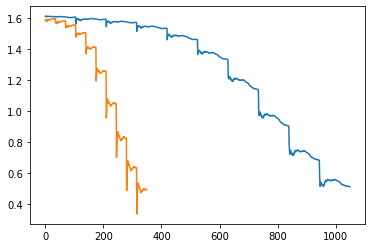

In [ ]:
# Model 1: MLP
mlp = MultiLayerPerceptron(input_size, hidden_size, output_size)
optimizer = optim.SGD(mlp.parameters(), lr=LEARNING_RATE, momentum=0.9)


mlp_trainer = MultiClassTrainer(mlp, optimizer, loss_fn)
mlp_trainer.run_training(train_tfidf_loader, valid_tfidf_loader, label_indexer.labels, n_epochs=10)

### MLP with L2 regularization (weight decay)

MultiLayerPerceptron(
  (fc1): Linear(in_features=26064, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
CrossEntropyLoss()



Epoch completed!
Epoch Loss:  1.6037446430751254
Epoch Perplexity:  4.971614532932292



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.23      1.00      0.37       128
entertainment       0.00      0.00      0.00        97
     business       0.00      0.00      0.00       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.23       556
    macro avg       0.05      0.20      0.07       556
 weighted avg       0.05      0.23      0.09       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.588161762555441
Epoch Perplexity:  4.894742953523929



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.23      1.00      0.38       128
entertainment       0.00      0.00      0.00        97
     business       1.00      0.09      0.16       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.25       556
    macro avg       0.25      0.22      0.11       556
 weighted avg       0.28      0.25      0.12       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5655086664926439
Epoch Perplexity:  4.785108341223775



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.26      1.00      0.42       128
entertainment       0.00      0.00      0.00        97
     business       1.00      0.56      0.72       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.36       556
    macro avg       0.25      0.31      0.23       556
 weighted avg       0.29      0.36      0.26       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5235662517093485
Epoch Perplexity:  4.588560010779571



Classification report after epoch:
               precision    recall  f1-score   support

         tech       1.00      0.01      0.02       100
        sport       0.34      1.00      0.51       128
entertainment       0.00      0.00      0.00        97
     business       0.73      0.91      0.81       127
     politics       1.00      0.20      0.34       104

     accuracy                           0.48       556
    macro avg       0.61      0.42      0.33       556
 weighted avg       0.61      0.48      0.37       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.4450436546688994
Epoch Perplexity:  4.242037323513221



Classification report after epoch:
               precision    recall  f1-score   support

         tech       1.00      0.58      0.73       100
        sport       0.58      1.00      0.74       128
entertainment       1.00      0.09      0.17        97
     business       0.64      0.97      0.77       127
     politics       0.99      0.74      0.85       104

     accuracy                           0.71       556
    macro avg       0.84      0.68      0.65       556
 weighted avg       0.82      0.71      0.67       556




Epoch completed!
Epoch Loss:  1.3077976022447861
Epoch Perplexity:  3.698020225452206



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.99      0.94      0.96       100
        sport       0.93      1.00      0.97       128
entertainment       1.00      0.65      0.79        97
     business       0.79      0.98      0.88       127
     politics       0.93      0.92      0.93       104

     accuracy                           0.91       556
    macro avg       0.93      0.90      0.90       556
 weighted avg       0.92      0.91      0.91       556




Epoch completed!
Epoch Loss:  1.104085380690438
Epoch Perplexity:  3.01646429025621



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.98      0.99      0.99       100
        sport       0.99      0.99      0.99       128
entertainment       1.00      0.86      0.92        97
     business       0.92      0.96      0.94       127
     politics       0.90      0.96      0.93       104

     accuracy                           0.96       556
    macro avg       0.96      0.95      0.95       556
 weighted avg       0.96      0.96      0.95       556




Epoch completed!
Epoch Loss:  0.8668215394020078
Epoch Perplexity:  2.379336195678168



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.98      1.00      0.99       100
        sport       1.00      0.98      0.99       128
entertainment       0.97      0.92      0.94        97
     business       0.96      0.95      0.96       127
     politics       0.92      0.98      0.95       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556




Epoch completed!
Epoch Loss:  0.6509199318431673
Epoch Perplexity:  1.9173038068047672



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.98      1.00      0.99       100
        sport       1.00      0.98      0.99       128
entertainment       0.97      0.96      0.96        97
     business       0.97      0.96      0.96       127
     politics       0.95      0.98      0.97       104

     accuracy                           0.97       556
    macro avg       0.97      0.98      0.97       556
 weighted avg       0.98      0.97      0.97       556




Epoch completed!
Epoch Loss:  0.4858772144431161
Epoch Perplexity:  1.6256003837084418



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.98      0.99      0.99       100
        sport       1.00      0.98      0.99       128
entertainment       0.96      0.98      0.97        97
     business       0.98      0.96      0.97       127
     politics       0.96      0.98      0.97       104

     accuracy                           0.98       556
    macro avg       0.98      0.98      0.98       556
 weighted avg       0.98      0.98      0.98       556



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


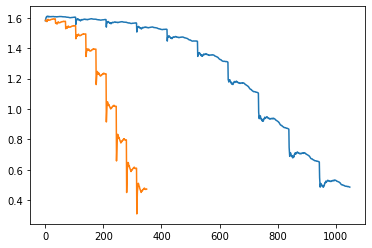

In [ ]:
# Model 2: Regularized MLP
mlp_regularized = MultiLayerPerceptron(input_size, hidden_size, output_size)
optimizer_regularized = optim.SGD(mlp_regularized.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4) # Add l2 regularization

mlp_regularized_trainer = MultiClassTrainer(mlp_regularized, optimizer_regularized, loss_fn)
mlp_regularized_trainer.run_training(train_tfidf_loader, valid_tfidf_loader, label_indexer.labels, n_epochs=10)

### MLP with Dropout

MultiLayerPerceptron(
  (fc1): Linear(in_features=26064, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
CrossEntropyLoss()



Epoch completed!
Epoch Loss:  1.603086251304263
Epoch Perplexity:  4.9683423401465125



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.23      1.00      0.37       128
entertainment       0.00      0.00      0.00        97
     business       0.00      0.00      0.00       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.23       556
    macro avg       0.05      0.20      0.07       556
 weighted avg       0.05      0.23      0.09       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5857620523089453
Epoch Perplexity:  4.883011070893819



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.24      1.00      0.39       128
entertainment       0.00      0.00      0.00        97
     business       1.00      0.21      0.35       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.28       556
    macro avg       0.25      0.24      0.15       556
 weighted avg       0.28      0.28      0.17       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5592245839890968
Epoch Perplexity:  4.755132609249833



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.00      0.00      0.00       100
        sport       0.29      1.00      0.45       128
entertainment       0.00      0.00      0.00        97
     business       0.82      0.76      0.79       127
     politics       0.00      0.00      0.00       104

     accuracy                           0.40       556
    macro avg       0.22      0.35      0.25       556
 weighted avg       0.25      0.40      0.28       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.5108756735211328
Epoch Perplexity:  4.530696468672736



Classification report after epoch:
               precision    recall  f1-score   support

         tech       1.00      0.09      0.17       100
        sport       0.42      1.00      0.59       128
entertainment       0.00      0.00      0.00        97
     business       0.55      0.94      0.70       127
     politics       0.97      0.27      0.42       104

     accuracy                           0.51       556
    macro avg       0.59      0.46      0.38       556
 weighted avg       0.58      0.51      0.40       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch completed!
Epoch Loss:  1.420383491970244
Epoch Perplexity:  4.138707296974119



Classification report after epoch:
               precision    recall  f1-score   support

         tech       1.00      0.72      0.84       100
        sport       0.68      1.00      0.81       128
entertainment       1.00      0.09      0.17        97
     business       0.60      0.98      0.74       127
     politics       0.99      0.78      0.87       104

     accuracy                           0.74       556
    macro avg       0.85      0.71      0.69       556
 weighted avg       0.83      0.74      0.70       556




Epoch completed!
Epoch Loss:  1.2700998578752793
Epoch Perplexity:  3.5612081592808615



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.98      0.95      0.96       100
        sport       0.95      1.00      0.97       128
entertainment       1.00      0.59      0.74        97
     business       0.74      0.98      0.84       127
     politics       0.94      0.90      0.92       104

     accuracy                           0.90       556
    macro avg       0.92      0.88      0.89       556
 weighted avg       0.91      0.90      0.89       556




Epoch completed!
Epoch Loss:  1.0598190080551877
Epoch Perplexity:  2.8858486266423005



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.95      0.99      0.97       100
        sport       0.98      0.99      0.99       128
entertainment       1.00      0.79      0.89        97
     business       0.88      0.96      0.92       127
     politics       0.91      0.93      0.92       104

     accuracy                           0.94       556
    macro avg       0.94      0.93      0.94       556
 weighted avg       0.94      0.94      0.94       556




Epoch completed!
Epoch Loss:  0.8282158153397698
Epoch Perplexity:  2.2892306841547496



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.97      0.99      0.98       100
        sport       1.00      0.98      0.99       128
entertainment       0.98      0.94      0.96        97
     business       0.94      0.97      0.95       127
     politics       0.94      0.95      0.95       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556




Epoch completed!
Epoch Loss:  0.6274890286581859
Epoch Perplexity:  1.8729018671033966



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.97      0.99      0.98       100
        sport       1.00      0.98      0.99       128
entertainment       0.97      0.95      0.96        97
     business       0.95      0.96      0.95       127
     politics       0.95      0.96      0.96       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556




Epoch completed!
Epoch Loss:  0.4767239476953235
Epoch Perplexity:  1.6107887207349105



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.97      0.99      0.98       100
        sport       0.99      0.98      0.99       128
entertainment       0.96      0.97      0.96        97
     business       0.98      0.96      0.97       127
     politics       0.96      0.96      0.96       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


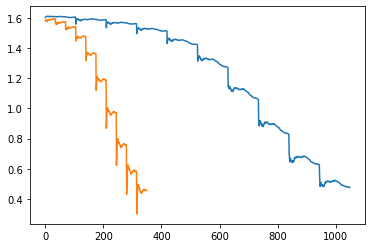

In [ ]:
# Model 2: MLP with dropout
mlp_with_dropout = MultiLayerPerceptron(input_size, hidden_size, output_size, dropout=True)
mlp_with_dropout_optimizer = optim.SGD(mlp_with_dropout.parameters(), lr=LEARNING_RATE, momentum=0.9)

mlp_with_dropout_trainer = MultiClassTrainer(mlp_with_dropout, mlp_with_dropout_optimizer, loss_fn)
mlp_with_dropout_trainer.run_training(train_tfidf_loader, valid_tfidf_loader, label_indexer.labels, n_epochs=10)

### Text Convolutional Models

In [ ]:
sequencer = W2VSequencer(word2vec_weights)

sequence_input_transformer = lambda text: sequencer.encode(text)

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor = sequencer.create_padded_tensor(texts)
    return (text_tensor, torch.stack(labels))

train_sequence_dataset = BBCNewsDataset(train_texts, train_labels, sequence_input_transformer, output_transformer)
valid_sequence_dataset = BBCNewsDataset(valid_texts, valid_labels, sequence_input_transformer, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=50, collate_fn=lambda batch: prepare_batch(batch, sequencer))
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=50, collate_fn=lambda batch: prepare_batch(batch, sequencer))

In [ ]:
print(device)

cuda


TextConvolver(
  (embedding): Embedding(302867, 300)
  (frozen_embedding): Embedding(302867, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(600, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(600, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(600, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=5, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
CrossEntropyLoss()


Running loss:  1.6157742738723755
Running loss:  1.8458691835403442
Running loss:  1.781106168573553
Running loss:  1.7638466507196429
Running loss:  1.7247755811327983
Running loss:  1.6798836726408741
Running loss:  1.6314924109366635

Epoch completed!
Epoch Loss:  1.604527568115908
Epoch Perplexity:  4.975508458570282



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.69      0.97      0.81       100
        sport       1.00      0.21      0.35       128
entertainment       0.51      0.96      0.66        97
     business       0.00      0.00      0.00       127
     politics       0.50      1.00      0.67       104

     accuracy                           0.58       556
    macro avg       0.54      0.63      0.50       556
 weighted avg       0.54      0.58      0.47       556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running loss:  1.296862006187439
Running loss:  1.2304476499557495
Running loss:  1.1928872195157139
Running loss:  1.1344164423644543
Running loss:  1.0815222972915286
Running loss:  1.0168285690821135
Running loss:  0.9612768734655073

Epoch completed!
Epoch Loss:  0.9355063105330748
Epoch Perplexity:  2.5485034652872978



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.89      0.98      0.93       100
        sport       0.98      0.98      0.98       128
entertainment       0.99      0.97      0.98        97
     business       0.95      0.88      0.91       127
     politics       0.95      0.96      0.96       104

     accuracy                           0.95       556
    macro avg       0.95      0.96      0.95       556
 weighted avg       0.95      0.95      0.95       556



Running loss:  0.5005470514297485
Running loss:  0.5472175876299541
Running loss:  0.5190220827406103
Running loss:  0.4964552484452725
Running loss:  0.4718257075264341
Running loss:  0.44028865947173196
Running loss:  0.41653082159257704

Epoch completed!
Epoch Loss:  0.40795355509309206
Epoch Perplexity:  1.503737318608432



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.94      0.97      0.96       100
        sport       0.98      1.00      0.99       128
entertainment       1.00      0.97      0.98        97
     business       0.95      0.92      0.94       127
     politics       0.95      0.96      0.96       104

     accuracy                           0.96       556
    macro avg       0.96      0.96      0.96       556
 weighted avg       0.96      0.96      0.96       556



Running loss:  0.19028915464878082
Running loss:  0.2593185802300771
Running loss:  0.2569218711419539
Running loss:  0.2560050906613469
Running loss:  0.2604128264245533
Running loss:  0.24507351678151354
Running loss:  0.23422415482421075

Epoch completed!
Epoch Loss:  0.23127458660918124
Epoch Perplexity:  1.2602052274254962



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.96      0.97      0.97       100
        sport       0.98      1.00      0.99       128
entertainment       1.00      0.98      0.99        97
     business       0.95      0.94      0.94       127
     politics       0.96      0.96      0.96       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556



Running loss:  0.12023082375526428
Running loss:  0.16675616055727005
Running loss:  0.16743096980181607
Running loss:  0.17574846278876066
Running loss:  0.18661800736472717
Running loss:  0.17237056763126296
Running loss:  0.16268969495450294

Epoch completed!
Epoch Loss:  0.1619370921569712
Epoch Perplexity:  1.1757862728161388



Classification report after epoch:
               precision    recall  f1-score   support

         tech       0.96      0.97      0.97       100
        sport       0.98      1.00      0.99       128
entertainment       1.00      0.98      0.99        97
     business       0.96      0.93      0.94       127
     politics       0.94      0.96      0.95       104

     accuracy                           0.97       556
    macro avg       0.97      0.97      0.97       556
 weighted avg       0.97      0.97      0.97       556



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


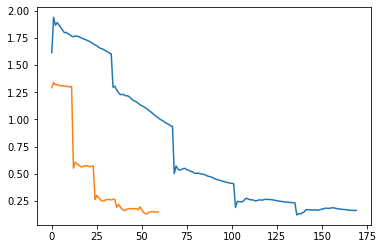

In [ ]:
cnn = TextConvolver(input_size, output_size, [3, 4, 5], channel_size=100, dropout_p=0.5, w2v_weights=torch.FloatTensor(word2vec_weights.vectors))
cnn_optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn_trainer = MultiClassTrainer(cnn, cnn_optimizer, loss_fn, device=device, log_every_n=5)
cnn_trainer.run_training(train_sequence_loader, valid_sequence_loader, label_indexer.labels, n_epochs=5)

## Saving the models

In [ ]:
cnn_state_dict = cnn_trainer.get_model_dict()

torch.save(cnn_state_dict, "cnn_checkpoint.pt")

## Restoring the models

In [ ]:
cnn_restored_state_dict = torch.load("cnn_checkpoint.pt")

# Configure the model the exact same way
cnn_restored = TextConvolver(input_size, output_size, [3, 4, 5], channel_size=100, dropout_p=0.5, w2v_weights=torch.FloatTensor(word2vec_weights.vectors))

# Restore state dict to load the same weights again
cnn_restored.load_state_dict(cnn_restored_state_dict)

<All keys matched successfully>